In [5]:
from headers import *

In [72]:
class DMP():
	
	def __init__(self):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = self.alphaz/3
		
		self.time_steps = 100
		self.tau = self.time_steps

		self.dimensions = 2
		self.number_kernels = 100
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
		self.rollout_time = 100
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.pos_var = npy.zeros(self.dimensions)
		self.vel_var = npy.zeros(self.dimensions)
		self.acc_var = npy.zeros(self.dimensions)        
		self.force_var = npy.zeros(self.dimensions)        
		self.goal = npy.zeros(self.dimensions)

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
# 		t_range_2 = npy.linspace(0,self.time_steps,self.time_steps)        
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase
		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)

	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
		self.eta[:,0] = vector_phase*(self.demo_pos[self.time_steps-1,0]-self.demo_pos[0,0])
		self.eta[:,1] = vector_phase*(self.demo_pos[self.time_steps-1,1]-self.demo_pos[0,1])

	def learn_DMP(self):		
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))

	def save_DMP_parameters(self,file_suffix):

		with file("force_weights_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile,self.weights)
	
		with file("position_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile, self.demo_pos)

	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP()


In [73]:
dmp = DMP()	
pos = npy.load("position.npy")
vel = npy.load("velocity.npy")
acc = npy.load("acceleration.npy")
dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
# dmp.update_target_force()
dmp.update_target_force_itau()
dmp.learn_DMP()

In [74]:
dmp.vector_phase.shape

(100,)

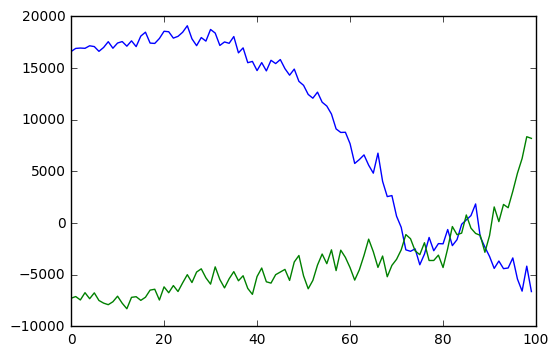

In [75]:
tr = npy.linspace(0,99,100)
plt.plot(tr, dmp.target_forces)
plt.show()

In [76]:
dmp = DMP()	
pos = npy.load("position.npy")
vel = npy.load("velocity.npy")
acc = npy.load("acceleration.npy")
dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
dmp.update_target_force()
# dmp.update_target_force_itau()
dmp.learn_DMP()

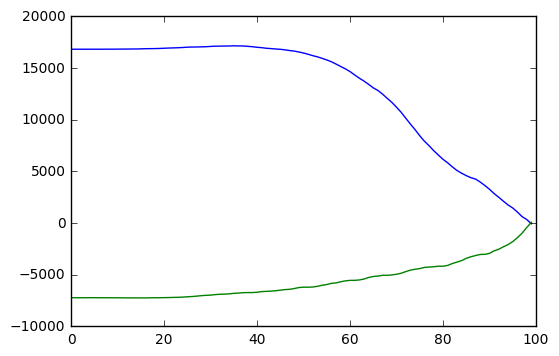

In [77]:
tr = npy.linspace(0,99,100)
plt.plot(tr, dmp.target_forces)
plt.show()

In [78]:
dmp.target_forces
# dmp.weights

array([[ 16827.22560529,  -7220.09819268],
       [ 16827.29533534,  -7220.02409243],
       [ 16827.41609332,  -7220.27609716],
       [ 16827.55518212,  -7219.46099247],
       [ 16828.28110582,  -7219.69801597],
       [ 16828.98139761,  -7218.39871192],
       [ 16828.34979832,  -7219.25765878],
       [ 16829.04172622,  -7221.2159872 ],
       [ 16832.2698672 ,  -7224.19782874],
       [ 16832.85827156,  -7226.26274475],
       [ 16836.30491381,  -7225.64310465],
       [ 16841.01983907,  -7229.01045789],
       [ 16843.27170587,  -7236.30083365],
       [ 16849.40685361,  -7236.37851719],
       [ 16851.70908821,  -7235.82187193],
       [ 16862.64320885,  -7238.00781902],
       [ 16877.90193454,  -7237.61501328],
       [ 16884.23570433,  -7230.47072791],
       [ 16890.32404138,  -7221.72979151],
       [ 16901.63018029,  -7223.54519689],
       [ 16921.46303934,  -7211.29921439],
       [ 16941.95724974,  -7204.994057  ],
       [ 16955.63072721,  -7189.78599865],
       [ 16

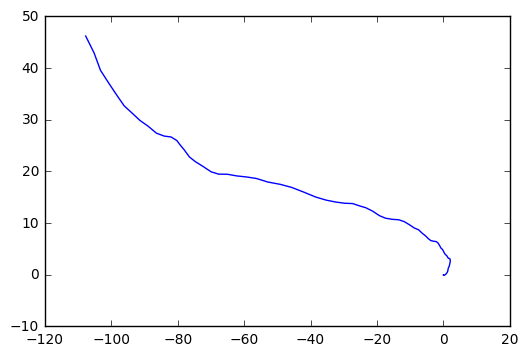

In [79]:
plt.plot(dmp.demo_pos[:,0],dmp.demo_pos[:,1])
plt.show()
# dmp.demo_pos

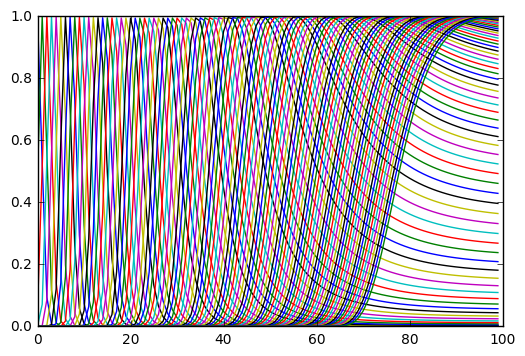

In [83]:
b = npy.zeros((dmp.number_kernels,100))
for i in range(100):
    for t in range(100):
        b[i,t]=dmp.basis(dmp.number_kernels*i/100,t)        
    plt.plot(tr,b[i])    

plt.show()

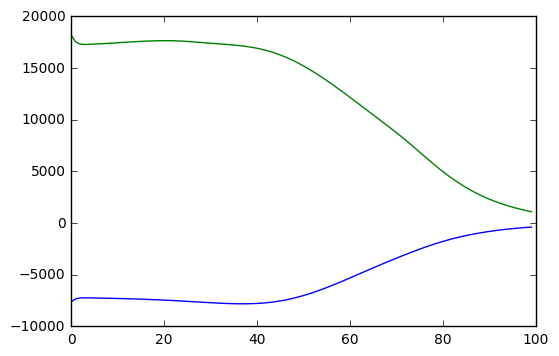

In [84]:
force = npy.zeros((100,2))
dmp.goal = npy.array([-110,46])

for t in range(100):
    den = 0
    for i in range(dmp.number_kernels):
        force[t] += dmp.weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)
    force[t,0]*=dmp.goal[1]*dmp.calc_phase(t)/den
    force[t,1]*=dmp.goal[0]*dmp.calc_phase(t)/den
    
plt.plot(tr,force)
plt.show()

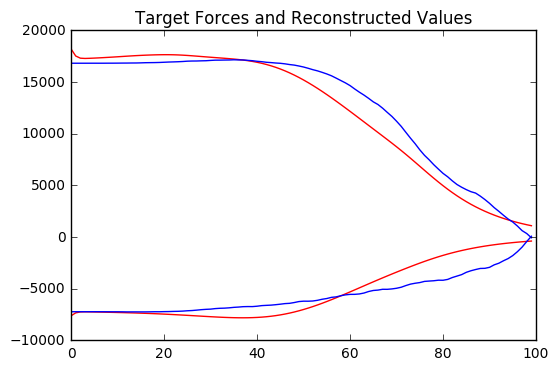

In [85]:
plt.plot(tr,force,'r')
plt.plot(tr,dmp.target_forces,'b')
plt.title("Target Forces and Reconstructed Values")
plt.show()